In [2]:
# !pip3 install -r requirements.txt

  Using cached numpy-1.21.0.zip (10.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pandas-2.0.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached scikit_learn-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 366.4 kB/s eta 0:00:00 kB/s eta 0:00:01:01
INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 710.6 kB/s eta 0:00:0031m28.1 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 485.4 kB/s eta 0:00:0031m3.5 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 381.3 kB/s eta 0:00:0031m24.2 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/3

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

import pandas as pd
import numpy as np
#import seaborn as sn
from src.pre_processamento.PreProcessamento import PreProcessamento
from src.pre_processamento.utils import * 
from src.modelagem.Modelagem import Modelagem

In [2]:
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)

In [3]:
caminhoDadosEstatisticos  = 'data/application_train.csv'

In [4]:
base_treinamento = pd.read_csv(caminhoDadosEstatisticos)

In [5]:
base_treinamento2 = remove_null_over(base_treinamento,over_porc=0.2)

Eliminando coluna OWN_CAR_AGE -> 0.6599081008484249 null
Eliminando coluna OCCUPATION_TYPE -> 0.31345545362604915 null
Eliminando coluna EXT_SOURCE_1 -> 0.5638107254699832 null
Eliminando coluna APARTMENTS_AVG -> 0.5074972927797705 null
Eliminando coluna BASEMENTAREA_AVG -> 0.5851595552679416 null
Eliminando coluna YEARS_BEGINEXPLUATATION_AVG -> 0.48781019215572774 null
Eliminando coluna YEARS_BUILD_AVG -> 0.6649778381911542 null
Eliminando coluna COMMONAREA_AVG -> 0.6987229725115525 null
Eliminando coluna ELEVATORS_AVG -> 0.532959796560123 null
Eliminando coluna ENTRANCES_AVG -> 0.503487680115508 null
Eliminando coluna FLOORSMAX_AVG -> 0.4976082156410665 null
Eliminando coluna FLOORSMIN_AVG -> 0.6784862980511266 null
Eliminando coluna LANDAREA_AVG -> 0.5937673774271489 null
Eliminando coluna LIVINGAPARTMENTS_AVG -> 0.6835495315614726 null
Eliminando coluna LIVINGAREA_AVG -> 0.5019332641759157 null
Eliminando coluna NONLIVINGAPARTMENTS_AVG -> 0.6943296337366793 null
Eliminando coluna N

In [6]:
base_treinamento2.select_dtypes(include='object')['NAME_TYPE_SUITE'].value_counts()

NAME_TYPE_SUITE
Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: count, dtype: int64

In [7]:
pre_proce = PreProcessamento(base_treinamento2)

In [8]:
base_treinamento2 = pre_proce.apply_method_encoding()

In [9]:
ivs = show_iv(base_treinamento2.fillna(-1))

SK_ID_CURR: 18.414902367696026
NAME_CONTRACT_TYPE: 0.015038762740893805
CODE_GENDER: 0.038712611049598354
FLAG_OWN_CAR: 0.006596551292123774
FLAG_OWN_REALTY: 0.0005054519178640686
CNT_CHILDREN: 0.008040987692185727
AMT_INCOME_TOTAL: 0.17646086882866763
AMT_CREDIT: 0.7448226302192215
AMT_ANNUITY: 1.9018222720289395
AMT_GOODS_PRICE: 0.19625213516557677
NAME_TYPE_SUITE: 0.0020859951711449214
NAME_INCOME_TYPE: 0.05925928487949578
NAME_EDUCATION_TYPE: 0.05083552212634242
NAME_FAMILY_STATUS: 0.021750658594402165
NAME_HOUSING_TYPE: 0.01573019571207511
REGION_POPULATION_RELATIVE: 0.0746643743374501
DAYS_BIRTH: 2.7293068710129615
DAYS_EMPLOYED: 1.4018675615608007
DAYS_REGISTRATION: 1.9387657212889893
DAYS_ID_PUBLISH: 0.5180497507303463
FLAG_MOBIL: 2.395208114766525e-05
FLAG_EMP_PHONE: 0.03290712507532642
FLAG_WORK_PHONE: 0.010328574420608846
FLAG_CONT_MOBILE: 1.8705050759336093e-06
FLAG_PHONE: 0.0079417140115913
FLAG_EMAIL: 4.210258547946649e-05
CNT_FAM_MEMBERS: 0.007186517654345645
REGION_RATI

In [10]:
correlacao = base_treinamento2[['TARGET', 'DAYS_LAST_PHONE_CHANGE','EXT_SOURCE_3','EXT_SOURCE_2','NAME_INCOME_TYPE_Working','NAME_EDUCATION_TYPE_Higher education','AMT_CREDIT','DAYS_EMPLOYED','DAYS_BIRTH','DAYS_ID_PUBLISH','DAYS_REGISTRATION','REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY','DEF_30_CNT_SOCIAL_CIRCLE']].corr()

In [11]:
variaveis_teste = ['TARGET', 'DAYS_LAST_PHONE_CHANGE','EXT_SOURCE_3','EXT_SOURCE_2','NAME_INCOME_TYPE_Working','NAME_EDUCATION_TYPE_Higher education','AMT_CREDIT','DAYS_EMPLOYED','DAYS_BIRTH','DAYS_ID_PUBLISH','DAYS_REGISTRATION','REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY','DEF_30_CNT_SOCIAL_CIRCLE']

<Axes: >

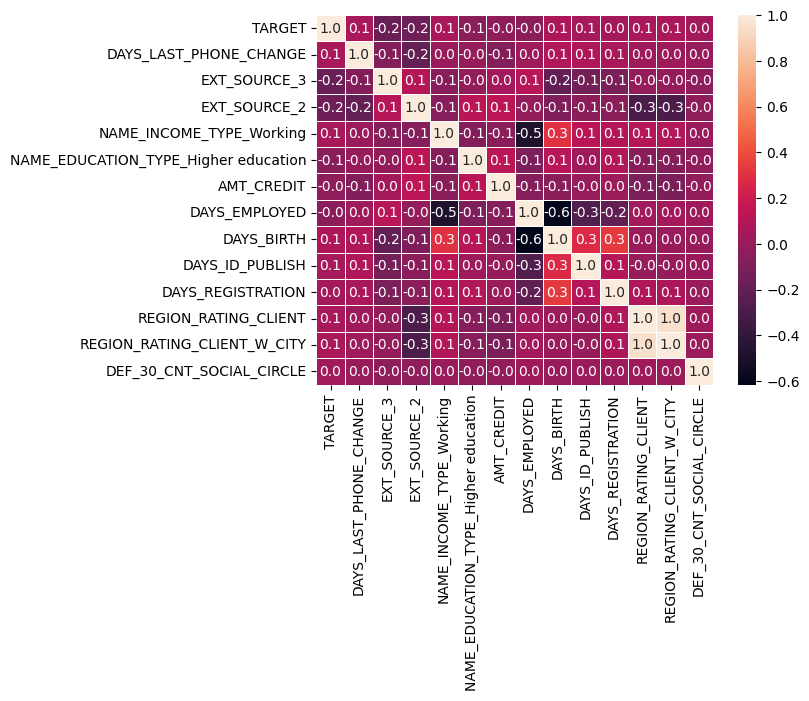

In [12]:
import seaborn as sn
sn.heatmap(correlacao, annot = True, fmt=".1f", linewidths=.6)

In [13]:
base_treinamento2 = base_treinamento2[variaveis_teste]

In [14]:
base_treinamento2

,TARGET,DAYS_LAST_PHONE_CHANGE,EXT_SOURCE_3,EXT_SOURCE_2,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,AMT_CREDIT,DAYS_EMPLOYED,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_REGISTRATION,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,DEF_30_CNT_SOCIAL_CIRCLE
0,1,-1134.0,0.139376,0.262949,1.0,0.0,406597.5,-637,-9461,-2120,-3648.0,2,2,2.0
1,0,-828.0,NaN,0.622246,0.0,1.0,1293502.5,-1188,-16765,-291,-1186.0,1,1,0.0
2,0,-815.0,0.729567,0.555912,1.0,0.0,135000.0,-225,-19046,-2531,-4260.0,2,2,0.0
3,0,-617.0,NaN,0.650442,1.0,0.0,312682.5,-3039,-19005,-2437,-9833.0,2,2,0.0
4,0,-1106.0,NaN,0.322738,1.0,0.0,513000.0,-3038,-19932,-3458,-4311.0,2,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,-273.0,NaN,0.681632,1.0,0.0,254700.0,-236,-9327,-1982,-8456.0,1,1,0.0
307507,0,0.0,NaN,0.115992,0.0,0.0,269550.0,365243,-20775,-4090,-4388.0,2,2,0.0
307508,0,-1909.0,0.218859,0.535722,1.0,1.0,677664.0,-7921,-14966,-5150,-6737.0,3,3,0.0
307509,1,-322.0,0.661024,0.514163,0.0,0.0,370107.0,-4786,-11961,-931,-2562.0,2,2,0.0


In [15]:
parametros = {
    'objective': 'binary',
    'boosting_type': 'rf',
    # 'num_leaves': 20,
    'max_depth': 10,
    'n_estimators':20,
    'learning_rate': 0.1,
    'feature_fraction': 0.4,
    'class_weight':'balanced',
    'random_state' : 0
}
model_random_forest = Modelagem(base_treinamento2,'TARGET')

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 17358, number of negative: 197899
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2015
[LightGBM] [Info] Number of data points in the train set: 215257, number of used

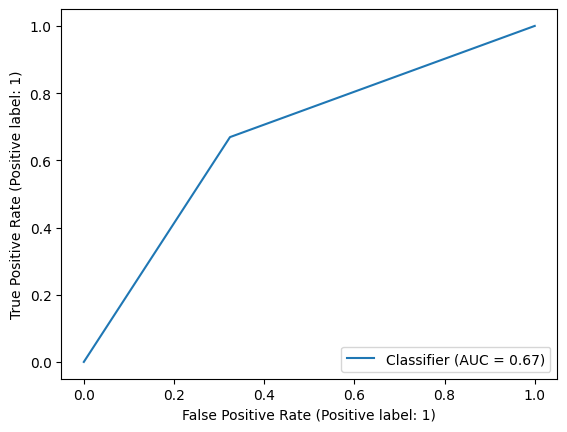

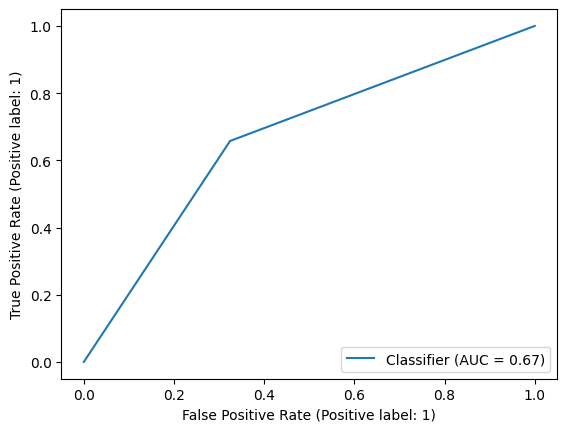

In [16]:
model_random_forest.set_model('lgb',parametros)
model_random_forest.train_model()

In [17]:
model_random_forest.apply_cross_validation()

[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2015
[LightGBM] [Info] Number of data points in the train set: 246008, number of used

In [49]:
from sklearn.model_selection import train_test_split
from  sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay

X_train, X_test, Y_train, Y_test = train_test_split(base_treinamento2[variaveis_teste].drop('TARGET',axis=1),base_treinamento2['TARGET'], test_size=0.3, random_state=0)

In [69]:
# clf = LogisticRegression(random_state=0)
# clf.fit(X_train.fillna(-1), Y_train)
# y_train_pred = clf.predict(X_train.fillna(-1))
# y_test_pred = clf.predict(X_test.fillna(-1))

In [37]:
clf  = RandomForestClassifier(class_weight='balanced',n_estimators=200, max_depth=10 ,min_samples_split=10, min_samples_leaf=10, max_features='sqrt',bootstrap=True, random_state=0)
clf.fit(X_train.fillna(-1), Y_train)
y_train_pred = clf.predict(X_train.fillna(-1))
y_test_pred = clf.predict(X_test.fillna(-1))

              precision    recall  f1-score   support

           0       0.96      0.72      0.82    197772
           1       0.18      0.70      0.29     17485

    accuracy                           0.72    215257
   macro avg       0.57      0.71      0.55    215257
weighted avg       0.90      0.72      0.78    215257



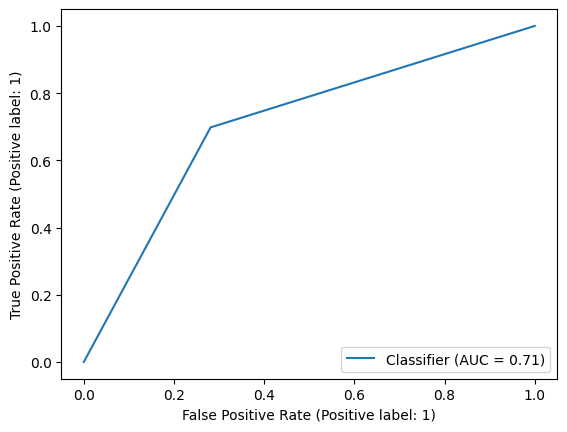

In [73]:
print(classification_report(Y_train, y_train_pred))
RocCurveDisplay.from_predictions(Y_train, y_train_pred)

              precision    recall  f1-score   support

           0       0.96      0.71      0.82     84914
           1       0.16      0.62      0.25      7340

    accuracy                           0.70     92254
   macro avg       0.56      0.67      0.53     92254
weighted avg       0.89      0.70      0.77     92254



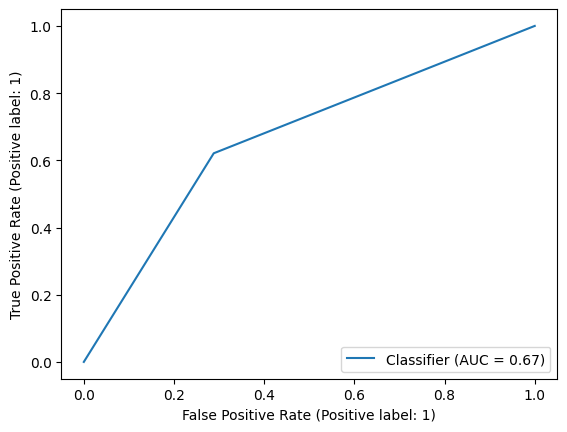

In [74]:
print(classification_report(Y_test, y_test_pred))
RocCurveDisplay.from_predictions(Y_test, y_test_pred)

In [80]:
import lightgbm.LGBMClassifier

ModuleNotFoundError: No module named 'lightgbm.LGBMClassifier'

In [6]:
base_treinamento[['SK_ID_CURR']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 1 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   SK_ID_CURR  307511 non-null  int64
dtypes: int64(1)
memory usage: 2.3 MB


In [14]:
list(base_treinamento.columns)

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

In [17]:
pd.qcut(base_treinamento['DAYS_EMPLOYED'],5).value_counts()

(-822.0, -144.0]         61574
(-17912.001, -3231.0]    61516
(-3231.0, -1695.0]       61506
(-1695.0, -822.0]        61490
(-144.0, 365243.0]       61425
Name: DAYS_EMPLOYED, dtype: int64

In [18]:
base_treinamento.groupby(['TARGET',pd.qcut(base_treinamento['DAYS_EMPLOYED'],5) ])['FLAG_OWN_CAR'].count()

TARGET  DAYS_EMPLOYED        
0       (-17912.001, -3231.0]    58209
        (-3231.0, -1695.0]       56749
        (-1695.0, -822.0]        55299
        (-822.0, -144.0]         54624
        (-144.0, 365243.0]       57805
1       (-17912.001, -3231.0]     3307
        (-3231.0, -1695.0]        4757
        (-1695.0, -822.0]         6191
        (-822.0, -144.0]          6950
        (-144.0, 365243.0]        3620
Name: FLAG_OWN_CAR, dtype: int64

<AxesSubplot: >

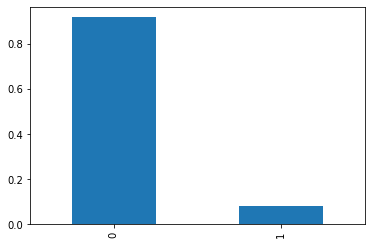

In [10]:
base_treinamento['TARGET'].value_counts(normalize=True).plot.bar()